In [35]:
import os
import glob

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from statannot import add_stat_annotation

import re

In [2]:
# Open SkySat datasets

data_20 = pd.read_csv('../data/img_scout_dfs/2020/INC_coreg_skysat_scout_2020.csv')
data_21 = pd.read_csv('../data/img_scout_dfs/2021/INC_skysat_scout_2021.csv')
data_22 = pd.read_csv('../data/img_scout_dfs/2022/INC_skysat_scout_2022.csv')

dfs = [data_20, data_21, data_22]

In [3]:
# Bin the NDVI values across all dates to get three ranges

all_years = pd.concat(dfs)
#all_years.head()
all_years['ndvi'] = (all_years['nir']-all_years['red'])/(all_years['nir']+all_years['red'])

#Check NDVI range to make sure it makes sense
# print(all_years['ndvi'].max())
# print(all_years['ndvi'].min())


In [4]:
ndvi_binned = pd.cut(all_years['ndvi'], 3, labels=["ndvi_low", "ndvi_med", "ndvi_high"])
ndvi_binned

0       ndvi_med
1       ndvi_med
2       ndvi_med
3       ndvi_med
4       ndvi_med
         ...    
715    ndvi_high
716     ndvi_med
717    ndvi_high
718    ndvi_high
719    ndvi_high
Name: ndvi, Length: 2414, dtype: category
Categories (3, object): ['ndvi_low' < 'ndvi_med' < 'ndvi_high']

In [5]:
# Get the numeric ranges of NDVI
ndvi_ranges = pd.cut(all_years['ndvi'], 3)
ndvi_ranges

0      (0.576, 0.72]
1      (0.576, 0.72]
2      (0.576, 0.72]
3      (0.576, 0.72]
4      (0.576, 0.72]
           ...      
715    (0.72, 0.864]
716    (0.576, 0.72]
717    (0.72, 0.864]
718    (0.72, 0.864]
719    (0.72, 0.864]
Name: ndvi, Length: 2414, dtype: category
Categories (3, interval[float64, right]): [(0.432, 0.576] < (0.576, 0.72] < (0.72, 0.864]]

## NDVI Ranges:

0.432 =< 0.576

0.576 =< 0.72

0.72 =< 0.864

## Label data by NDVI range + severity/incidence class

Create a combined label for each NDVI/disease class combo.

This will enable plotting all combos in the order of our choosing in a single box plot for each year.

Dates on x-axis. 6 boxes per date.

Possible order #1:

1. ndvi_low, disease_low
2. ndvi_med, disease_low
3. ndvi_high, disease low


4. ndvi_low, disease_high
5. ndvi_med, disease_high
6. ndvi_high, disease_high

Possible order #2:

1. ndvi_low, disease_low
2. ndvi_low, disease_high


3. ndvi_med, disease_low
4. ndvi_med, disease_high


5. ndvi_high, disease_low
6. ndvi_high, disease_high

Colors:  

disease_low = green  

disease_high = yellow  


Pattern:  

ndvi_low = dots  

ndvi_med = lines

ndvi_high = stars



In [6]:
# Add columns for vis, ndvi_bin, inc_class, sev_class

# Add VIs
def add_vis(df):
    df['ndvi']= (df['nir']-df['red'])/(df['nir']+df['red'])
    df['evi']= 2.5*(df['nir']-df['red'])/(df['nir']+6*df['red']-7.5*df['blue']+1)
    df['savi']= 1.5*(df['nir']-df['red'])/(df['nir']+df['red']+0.5)
    df['arvi']=(df['nir']-(2*df['red']-df['blue']))/(df['nir']+(2*df['red']-df['blue']))
    df['grvi']=(df['green']-df['red'])/(df['green']+df['red'])
    df['bgvi'] = df['blue']-df['green']/df['blue']+df['green']
    df['gcc']=df['green']/(df['green']+df['red']+df['blue'])
    df['gri']=df['green']/df['red']
    
    return df

In [7]:
for df in dfs:
    add_vis(df)
    
    df['inc_class'] = 'low'
    df.loc[df['DM_inc']>25,'inc_class']= 'high'
    
    df['sev_class'] = 'low'
    df.loc[df['DM_severity']>10,'sev_class']= 'high'
    
    df.loc[df['ndvi']<0.576,'ndvi_bin']= '< 0.576'
    df.loc[(df['ndvi']>= 0.576)&(df['ndvi']<0.72),'ndvi_bin']='0.576 - 0.72'
    df.loc[(df['ndvi']>= 0.72),'ndvi_bin']='>= 0.72'


In [8]:
# Create combined labels
# ndvi_sev = ndvi and severity
# ndvi_inc = ndvi and incidence

for df in dfs:
    #severity and ndvi
    df.loc[(df['ndvi_bin']=='< 0.576')&(df['sev_class']=='low'),'ndvi_sev']= 'low_n,low_s'
    df.loc[(df['ndvi_bin']=='< 0.576')&(df['sev_class']=='high'),'ndvi_sev']= 'low_n,high_s'
    
    df.loc[(df['ndvi_bin']=='0.576 - 0.72')&(df['sev_class']=='low'),'ndvi_sev']= 'med_n,low_s'
    df.loc[(df['ndvi_bin']=='0.576 - 0.72')&(df['sev_class']=='high'),'ndvi_sev']= 'med_n,high_s'
    
    df.loc[(df['ndvi_bin']=='>= 0.72')&(df['sev_class']=='low'),'ndvi_sev']= 'high_n,low_s'
    df.loc[(df['ndvi_bin']=='>= 0.72')&(df['sev_class']=='high'),'ndvi_sev']= 'high_n,high_s'
    
    #inc and ndvi
    df.loc[(df['ndvi_bin']=='< 0.576')&(df['inc_class']=='low'),'ndvi_inc']= 'low_n,low_i'
    df.loc[(df['ndvi_bin']=='< 0.576')&(df['inc_class']=='high'),'ndvi_inc']= 'low_n,high_i'
    
    df.loc[(df['ndvi_bin']=='0.576 - 0.72')&(df['inc_class']=='low'),'ndvi_inc']= 'med_n,low_i'
    df.loc[(df['ndvi_bin']=='0.576 - 0.72')&(df['inc_class']=='high'),'ndvi_inc']= 'med_n,high_i'
    
    df.loc[(df['ndvi_bin']=='>= 0.72')&(df['inc_class']=='low'),'ndvi_inc']= 'high_n,low_i'
    df.loc[(df['ndvi_bin']=='>= 0.72')&(df['inc_class']=='high'),'ndvi_inc']= 'high_n,high_i'

In [9]:
dfs[0].head()

,acquired,plot,blue,green,red,nir,row,panel,Date,Treatment,...,arvi,grvi,bgvi,gcc,gri,inc_class,sev_class,ndvi_bin,ndvi_sev,ndvi_inc
0,20200618,1,0.040044,0.077491,0.071216,0.353575,1,1,2020-06-18,5.0,...,0.550895,0.042197,-1.817615,0.410546,1.088113,low,low,0.576 - 0.72,"med_n,low_s","med_n,low_i"
1,20200618,2,0.044693,0.081807,0.077133,0.336587,1,2,2020-06-18,9.0,...,0.508816,0.029403,-1.703900,0.401735,1.060588,low,low,0.576 - 0.72,"med_n,low_s","med_n,low_i"
2,20200618,4,0.040121,0.076396,0.070693,0.343482,1,4,2020-06-18,18.0,...,0.544620,0.038776,-1.787612,0.408077,1.080681,low,low,0.576 - 0.72,"med_n,low_s","med_n,low_i"
3,20200618,5,0.034862,0.073497,0.060772,0.358279,1,5,2020-06-18,6.0,...,0.610381,0.094766,-1.999851,0.434554,1.209374,low,low,0.576 - 0.72,"med_n,low_s","med_n,low_i"
4,20200618,6,0.039300,0.075070,0.068893,0.337817,1,6,2020-06-18,2.0,...,0.548540,0.042904,-1.795808,0.409629,1.089656,low,low,0.576 - 0.72,"med_n,low_s","med_n,low_i"


In [11]:
dfs[0].Date.unique()

array(['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06',
       '2020-08-13'], dtype=object)

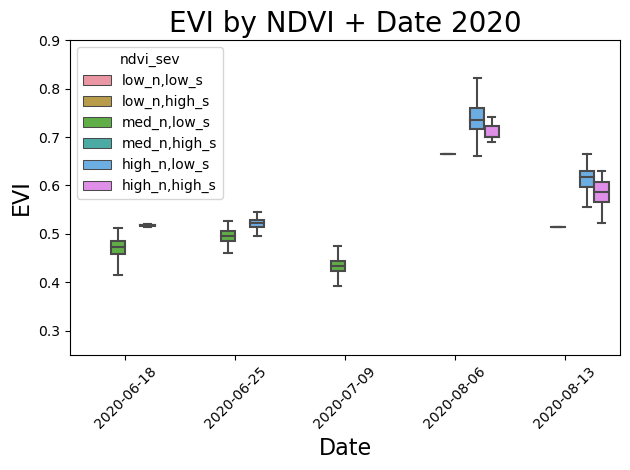

In [13]:
#Severity 2020

x = "Date"
y = "evi"
hue = "ndvi_sev"

hue_order=['low_n,low_s', 'low_n,high_s',
           'med_n,low_s', 'med_n,high_s',
          'high_n,low_s', 'high_n,high_s']

order = ['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06',
       '2020-08-13']
pairs=[
    ((order[0], 'low_n,low_s'), (order[0], 'low_n,high_s')),
    ((order[0], 'med_n,low_s'), (order[0], 'med_n,high_s')),
    ((order[0], 'high_n,low_s'), (order[0], 'high_n,high_s')),
    
    ((order[1], 'low_n,low_s'), (order[1], 'low_n,high_s')),
    ((order[1], 'med_n,low_s'), (order[1], 'med_n,high_s')),
    ((order[1], 'high_n,low_s'), (order[1], 'high_n,high_s')),
    
    ((order[2], 'low_n,low_s'), (order[2], 'low_n,high_s')),
    ((order[2], 'med_n,low_s'), (order[2], 'med_n,high_s')),
    ((order[2], 'high_n,low_s'), (order[2], 'high_n,high_s')),
    
    ((order[3], 'low_n,low_s'), (order[3], 'low_n,high_s')),
    ((order[3], 'med_n,low_s'), (order[3], 'med_n,high_s')),
    ((order[3], 'high_n,low_s'), (order[3], 'high_n,high_s')),

    ((order[4], 'low_n,low_s'), (order[4], 'low_n,high_s')),
    ((order[4], 'med_n,low_s'), (order[4], 'med_n,high_s')),
    ((order[4], 'high_n,low_s'), (order[4], 'high_n,high_s'))
    ]

colors = ["#4CAF50", "#FFDD33"]
sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=data_20, x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06','2020-08-13'], 
                   rotation=45)

# add_stat_annotation(ax, data=data_20, x=x, y=y, order=order, hue=hue, box_pairs=pairs,
#                     test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=16)
plt.ylabel("EVI", fontsize= 16)

plt.ylim(0.25, 0.9)
#plt.legend(title='Disease Severity',loc='upper left', labels=['<=10%', '>10%'], bbox_to_anchor=(1.02, 1))
##
#Test creating legend artist

# low_patch = mpatches.Patch(color='#4CAF50', label='<=10%')
# high_patch = mpatches.Patch(color='#FFDD33', label='>10%')

# plt.legend(title='GDM Severity',
#            loc='upper left',
#            #handles=[low_patch, high_patch],
#           bbox_to_anchor=(1.02, 1))

# plt.figtext(0.92, 0.5, 
#             'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001\n ****: p <= 1.00e-04', 
#             fontsize=12)

plt.title("EVI by NDVI + Date 2020", fontsize=20)

plt.tight_layout()
#plt.savefig("fig3_sev_2020.svg")

In [15]:
# Try binning by 2020 ndvi

ndvi_ranges_20 = pd.cut(dfs[0]['ndvi'], 3)
ndvi_ranges_20


0      (0.586, 0.679]
1      (0.586, 0.679]
2      (0.586, 0.679]
3      (0.679, 0.772]
4      (0.586, 0.679]
            ...      
494    (0.772, 0.864]
495    (0.772, 0.864]
496    (0.772, 0.864]
497    (0.772, 0.864]
498    (0.772, 0.864]
Name: ndvi, Length: 499, dtype: category
Categories (3, interval[float64, right]): [(0.586, 0.679] < (0.679, 0.772] < (0.772, 0.864]]

In [16]:
# Add column for 2020 ndvi bin

dfs[0].loc[dfs[0]['ndvi']<0.679,'ndvi_bin_20']= '< 0.679'
dfs[0].loc[(dfs[0]['ndvi']>= 0.679)&(dfs[0]['ndvi']<0.772),'ndvi_bin_20']='0.679 - 0.772'
dfs[0].loc[(dfs[0]['ndvi']>= 0.772),'ndvi_bin_20']='>= 0.772'

In [20]:
#severity and ndvi

dfs[0].loc[(dfs[0]['ndvi_bin_20']=='< 0.679')&(dfs[0]['sev_class']=='low'),'ndvi_sev_20']= 'low_n,low_s'
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='< 0.679')&(dfs[0]['sev_class']=='high'),'ndvi_sev_20']= 'low_n,high_s'
    
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='0.679 - 0.772')&(dfs[0]['sev_class']=='low'),'ndvi_sev_20']= 'med_n,low_s'
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='0.679 - 0.772')&(dfs[0]['sev_class']=='high'),'ndvi_sev_20']= 'med_n,high_s'
    
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='>= 0.772')&(dfs[0]['sev_class']=='low'),'ndvi_sev_20']= 'high_n,low_s'
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='>= 0.772')&(dfs[0]['sev_class']=='high'),'ndvi_sev_20']= 'high_n,high_s'
    

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2020-08-13_med_n,low_s v.s. 2020-08-13_med_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=0.000e+00
2020-08-13_high_n,low_s v.s. 2020-08-13_high_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=9.393e-04 U_stat=1.132e+03
2020-08-06_med_n,low_s v.s. 2020-08-06_med_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.600e+01
2020-08-06_high_n,low_s v.s. 2020-08-06_high_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.655e-01 U_stat=2.260e+02


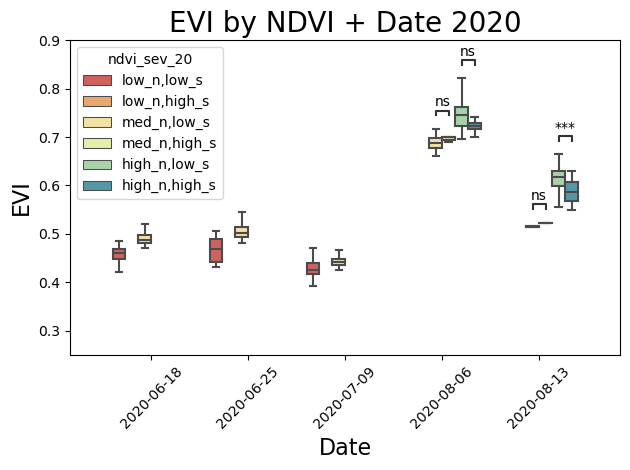

In [51]:
#Severity 2020

x = "Date"
y = "evi"
hue = "ndvi_sev_20"

hue_order=['low_n,low_s', 'low_n,high_s',
           'med_n,low_s', 'med_n,high_s',
          'high_n,low_s', 'high_n,high_s']

order = ['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06',
       '2020-08-13']
pairs=[
#     ((order[0], 'low_n,low_s'), (order[0], 'low_n,high_s')),
#     ((order[0], 'med_n,low_s'), (order[0], 'med_n,high_s')),
#     ((order[0], 'high_n,low_s'), (order[0], 'high_n,high_s')),
    
#     ((order[1], 'low_n,low_s'), (order[1], 'low_n,high_s')),
#     ((order[1], 'med_n,low_s'), (order[1], 'med_n,high_s')),
#     ((order[1], 'high_n,low_s'), (order[1], 'high_n,high_s')),
    
#     ((order[2], 'low_n,low_s'), (order[2], 'low_n,high_s')),
#     ((order[2], 'med_n,low_s'), (order[2], 'med_n,high_s')),
#     ((order[2], 'high_n,low_s'), (order[2], 'high_n,high_s')),
    
#     ((order[3], 'low_n,low_s'), (order[3], 'low_n,high_s')),
    ((order[3], 'med_n,low_s'), (order[3], 'med_n,high_s')),
    ((order[3], 'high_n,low_s'), (order[3], 'high_n,high_s')),

#     ((order[4], 'low_n,low_s'), (order[4], 'low_n,high_s')),
    ((order[4], 'med_n,low_s'), (order[4], 'med_n,high_s')),
    ((order[4], 'high_n,low_s'), (order[4], 'high_n,high_s'))
    ]

# colors = ["#4CAF50", "#FFDD33"]
# sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dfs[0], x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06','2020-08-13'], 
                   rotation=45)

add_stat_annotation(ax, data=dfs[0], x=x, y=y, order=order, hue=hue, hue_order=hue_order, box_pairs=pairs,
                     test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=16)
plt.ylabel("EVI", fontsize= 16)

plt.ylim(0.25, 0.9)
#plt.legend(title='Disease Severity',loc='upper left', labels=['<=10%', '>10%'], bbox_to_anchor=(1.02, 1))
##
#Test creating legend artist

# low_patch = mpatches.Patch(color='#4CAF50', label='<=10%')
# high_patch = mpatches.Patch(color='#FFDD33', label='>10%')

# plt.legend(title='GDM Severity',
#            loc='upper left',
#            #handles=[low_patch, high_patch],
#           bbox_to_anchor=(1.02, 1))

# plt.figtext(0.92, 0.5, 
#             'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001\n ****: p <= 1.00e-04', 
#             fontsize=12)

plt.title("EVI by NDVI + Date 2020", fontsize=20)

plt.tight_layout()
#plt.savefig("fig3_sev_2020.svg")

In [22]:
# incidence 2020

dfs[0].loc[(dfs[0]['ndvi_bin_20']=='< 0.679')&(dfs[0]['inc_class']=='low'),'ndvi_inc_20']= 'low_n,low_i'
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='< 0.679')&(dfs[0]['inc_class']=='high'),'ndvi_inc_20']= 'low_n,high_i'
    
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='0.679 - 0.772')&(dfs[0]['inc_class']=='low'),'ndvi_inc_20']= 'med_n,low_i'
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='0.679 - 0.772')&(dfs[0]['inc_class']=='high'),'ndvi_inc_20']= 'med_n,high_i'
    
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='>= 0.772')&(dfs[0]['inc_class']=='low'),'ndvi_inc_20']= 'high_n,low_i'
dfs[0].loc[(dfs[0]['ndvi_bin_20']=='>= 0.772')&(dfs[0]['inc_class']=='high'),'ndvi_inc_20']= 'high_n,high_i'

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2020-08-13_med_n,low_i v.s. 2020-08-13_med_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=0.000e+00
2020-08-13_high_n,low_i v.s. 2020-08-13_high_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.488e-02 U_stat=1.536e+03
2020-07-09_low_n,low_i v.s. 2020-07-09_low_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.608e-01 U_stat=0.000e+00
2020-08-06_med_n,low_i v.s. 2020-08-06_med_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.000e+01
2020-08-06_high_n,low_i v.s. 2020-08-06_high_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.885e-02 U_stat=1.080e+03
2020-07-09_med_n,low_i v.s. 2020-07-09_med_n,high_i: Mann-Whitney-Wilcoxon te

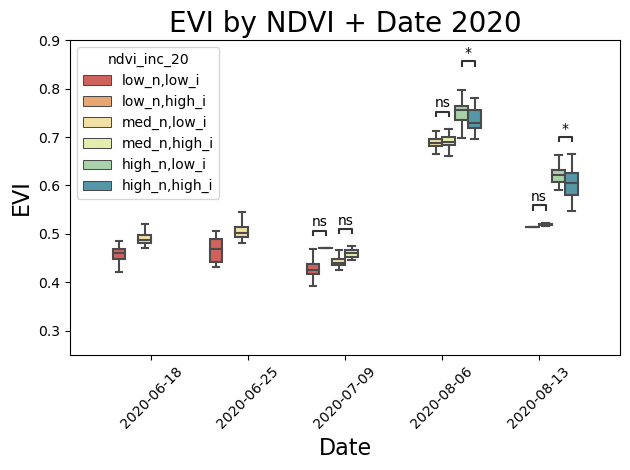

In [49]:
#Incidence 2020

x = "Date"
y = "evi"
hue = "ndvi_inc_20"

hue_order=['low_n,low_i', 'low_n,high_i',
           'med_n,low_i', 'med_n,high_i',
          'high_n,low_i', 'high_n,high_i']

order = ['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06',
       '2020-08-13']
pairs=[
#     ((order[0], 'low_n,low_i'), (order[0], 'low_n,high_i')),
#     ((order[0], 'med_n,low_i'), (order[0], 'med_n,high_i')),
#     ((order[0], 'high_n,low_i'), (order[0], 'high_n,high_i')),
    
#     ((order[1], 'low_n,low_i'), (order[1], 'low_n,high_i')),
#     ((order[1], 'med_n,low_i'), (order[1], 'med_n,high_i')),
#     ((order[1], 'high_n,low_i'), (order[1], 'high_n,high_i')),
    
    ((order[2], 'low_n,low_i'), (order[2], 'low_n,high_i')),
    ((order[2], 'med_n,low_i'), (order[2], 'med_n,high_i')),
#     ((order[2], 'high_n,low_i'), (order[2], 'high_n,high_i')),
    
#     ((order[3], 'low_n,low_i'), (order[3], 'low_n,high_i')),
    ((order[3], 'med_n,low_i'), (order[3], 'med_n,high_i')),
    ((order[3], 'high_n,low_i'), (order[3], 'high_n,high_i')),

#     ((order[4], 'low_n,low_i'), (order[4], 'low_n,high_i')),
    ((order[4], 'med_n,low_i'), (order[4], 'med_n,high_i')),
    ((order[4], 'high_n,low_i'), (order[4], 'high_n,high_i'))
    ]

# colors = ["#4CAF50", "#FFDD33"]
# sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dfs[0], x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['2020-06-18', '2020-06-25', '2020-07-09', '2020-08-06','2020-08-13'], 
                   rotation=45)

add_stat_annotation(ax, data=dfs[0], x=x, y=y, order=order, hue=hue, hue_order=hue_order, box_pairs=pairs,
                     test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=16)
plt.ylabel("EVI", fontsize= 16)

plt.ylim(0.25, 0.9)
#plt.legend(title='Disease Severity',loc='upper left', labels=['<=10%', '>10%'], bbox_to_anchor=(1.02, 1))
##
#Test creating legend artist

# low_patch = mpatches.Patch(color='#4CAF50', label='<=10%')
# high_patch = mpatches.Patch(color='#FFDD33', label='>10%')

# plt.legend(title='GDM Severity',
#            loc='upper left',
#            #handles=[low_patch, high_patch],
#           bbox_to_anchor=(1.02, 1))

# plt.figtext(0.92, 0.5, 
#             'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001\n ****: p <= 1.00e-04', 
#             fontsize=12)

plt.title("EVI by NDVI + Date 2020", fontsize=20)

plt.tight_layout()
#plt.savefig("fig3_sev_2020.svg")

In [24]:
# Try binning by 2021 ndvi

ndvi_ranges_21 = pd.cut(dfs[1]['ndvi'], 3)
ndvi_ranges_21

0       (0.677, 0.758]
1       (0.677, 0.758]
2       (0.677, 0.758]
3       (0.677, 0.758]
4        (0.758, 0.84]
             ...      
1190    (0.596, 0.677]
1191    (0.677, 0.758]
1192    (0.677, 0.758]
1193    (0.677, 0.758]
1194    (0.677, 0.758]
Name: ndvi, Length: 1195, dtype: category
Categories (3, interval[float64, right]): [(0.596, 0.677] < (0.677, 0.758] < (0.758, 0.84]]

In [25]:
# Add column for 2021 ndvi bin

dfs[1].loc[dfs[1]['ndvi']<0.677,'ndvi_bin_21']= '< 0.677'
dfs[1].loc[(dfs[1]['ndvi']>= 0.677)&(dfs[1]['ndvi']<0.758),'ndvi_bin_21']='0.677 - 0.758'
dfs[1].loc[(dfs[1]['ndvi']>= 0.758),'ndvi_bin_21']='>= 0.758'

#severity and ndvi

dfs[1].loc[(dfs[1]['ndvi_bin_21']=='< 0.677')&(dfs[1]['sev_class']=='low'),'ndvi_sev_21']= 'low_n,low_s'
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='< 0.677')&(dfs[1]['sev_class']=='high'),'ndvi_sev_21']= 'low_n,high_s'
    
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='0.677 - 0.758')&(dfs[1]['sev_class']=='low'),'ndvi_sev_21']= 'med_n,low_s'
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='0.677 - 0.758')&(dfs[1]['sev_class']=='high'),'ndvi_sev_21']= 'med_n,high_s'
    
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='>= 0.758')&(dfs[1]['sev_class']=='low'),'ndvi_sev_21']= 'high_n,low_s'
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='>= 0.758')&(dfs[1]['sev_class']=='high'),'ndvi_sev_21']= 'high_n,high_s'

# incidence 2021

dfs[1].loc[(dfs[1]['ndvi_bin_21']=='< 0.677')&(dfs[1]['inc_class']=='low'),'ndvi_inc_21']= 'low_n,low_i'
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='< 0.677')&(dfs[1]['inc_class']=='high'),'ndvi_inc_21']= 'low_n,high_i'
    
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='0.677 - 0.758')&(dfs[1]['inc_class']=='low'),'ndvi_inc_21']= 'med_n,low_i'
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='0.677 - 0.758')&(dfs[1]['inc_class']=='high'),'ndvi_inc_21']= 'med_n,high_i'
    
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='>= 0.758')&(dfs[1]['inc_class']=='low'),'ndvi_inc_21']= 'high_n,low_i'
dfs[1].loc[(dfs[1]['ndvi_bin_21']=='>= 0.758')&(dfs[1]['inc_class']=='high'),'ndvi_inc_21']= 'high_n,high_i'

In [26]:
dfs[1].Date.unique()

array(['2021-07-07', '2021-07-27', '2021-08-03', '2021-08-10',
       '2021-08-17'], dtype=object)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2021-08-17_med_n,low_s v.s. 2021-08-17_med_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.024e-02 U_stat=1.401e+03
2021-08-03_high_n,low_s v.s. 2021-08-03_high_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.344e-01 U_stat=1.819e+03
2021-08-10_med_n,low_s v.s. 2021-08-10_med_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.120e+02
2021-08-10_high_n,low_s v.s. 2021-08-10_high_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.548e+03
2021-08-17_low_n,low_s v.s. 2021-08-17_low_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.490e+02
2021-07-27_med_n,low_s v.s. 2021-07-27_med_n,high_s: Mann-Whitney-Wilcoxon te

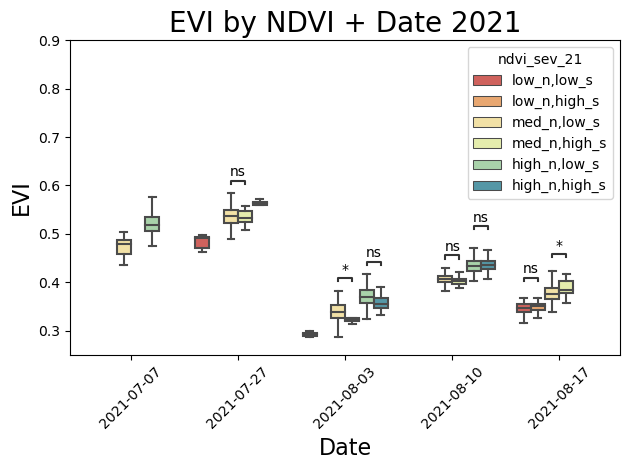

In [48]:
#Severity 2021

x = "Date"
y = "evi"
hue = "ndvi_sev_21"

hue_order=['low_n,low_s', 'low_n,high_s',
           'med_n,low_s', 'med_n,high_s',
          'high_n,low_s', 'high_n,high_s']

order = ['2021-07-07', '2021-07-27', '2021-08-03', '2021-08-10',
       '2021-08-17']
pairs=[
#     ((order[0], 'low_n,low_s'), (order[0], 'low_n,high_s')),
#     ((order[0], 'med_n,low_s'), (order[0], 'med_n,high_s')),
#     ((order[0], 'high_n,low_s'), (order[0], 'high_n,high_s')),
    
#     ((order[1], 'low_n,low_s'), (order[1], 'low_n,high_s')),
    ((order[1], 'med_n,low_s'), (order[1], 'med_n,high_s')),
#     ((order[1], 'high_n,low_s'), (order[1], 'high_n,high_s')),
    
#     ((order[2], 'low_n,low_s'), (order[2], 'low_n,high_s')),
    ((order[2], 'med_n,low_s'), (order[2], 'med_n,high_s')),
    ((order[2], 'high_n,low_s'), (order[2], 'high_n,high_s')),
    
#     ((order[3], 'low_n,low_s'), (order[3], 'low_n,high_s')),
    ((order[3], 'med_n,low_s'), (order[3], 'med_n,high_s')),
    ((order[3], 'high_n,low_s'), (order[3], 'high_n,high_s')),

    ((order[4], 'low_n,low_s'), (order[4], 'low_n,high_s')),
    ((order[4], 'med_n,low_s'), (order[4], 'med_n,high_s')),
#     ((order[4], 'high_n,low_s'), (order[4], 'high_n,high_s'))
    ]

# colors = ["#4CAF50", "#FFDD33"]
# sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dfs[1], x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['2021-07-07', '2021-07-27', '2021-08-03', '2021-08-10','2021-08-17'], 
                   rotation=45)

add_stat_annotation(ax, data=dfs[1], x=x, y=y, order=order, hue=hue, hue_order=hue_order, box_pairs=pairs,
                     test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=16)
plt.ylabel("EVI", fontsize= 16)

plt.ylim(0.25, 0.9)
#plt.legend(title='Disease Severity',loc='upper left', labels=['<=10%', '>10%'], bbox_to_anchor=(1.02, 1))
##
#Test creating legend artist

# low_patch = mpatches.Patch(color='#4CAF50', label='<=10%')
# high_patch = mpatches.Patch(color='#FFDD33', label='>10%')

# plt.legend(title='GDM Severity',
#            loc='upper left',
#            #handles=[low_patch, high_patch],
#           bbox_to_anchor=(1.02, 1))

# plt.figtext(0.92, 0.5, 
#             'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001\n ****: p <= 1.00e-04', 
#             fontsize=12)

plt.title("EVI by NDVI + Date 2021", fontsize=20)

plt.tight_layout()
#plt.savefig("fig3_sev_2020.svg")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2021-08-17_med_n,low_i v.s. 2021-08-17_med_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=4.760e-06 U_stat=1.716e+03
2021-07-07_high_n,low_i v.s. 2021-07-07_high_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.530e+02
2021-08-10_med_n,low_i v.s. 2021-08-10_med_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.890e+02
2021-08-10_high_n,low_i v.s. 2021-08-10_high_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.902e-03 U_stat=1.965e+03
2021-08-17_low_n,low_i v.s. 2021-08-17_low_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.748e-01 U_stat=2.430e+02
2021-07-27_med_n,low_i v.s. 2021-07-27_med_n,high_i: Mann-Whitney-Wilcoxon te

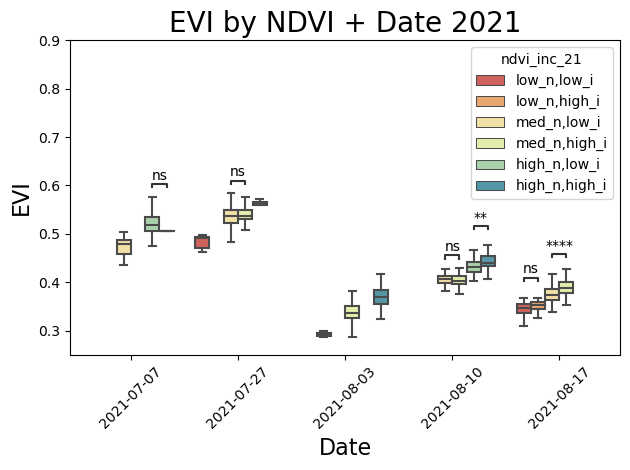

In [47]:
#Incidence 2021

x = "Date"
y = "evi"
hue = "ndvi_inc_21"

hue_order=['low_n,low_i', 'low_n,high_i',
           'med_n,low_i', 'med_n,high_i',
          'high_n,low_i', 'high_n,high_i']

order = ['2021-07-07', '2021-07-27', '2021-08-03', '2021-08-10','2021-08-17']
pairs=[
#     ((order[0], 'low_n,low_i'), (order[0], 'low_n,high_i')),
#     ((order[0], 'med_n,low_i'), (order[0], 'med_n,high_i')),
    ((order[0], 'high_n,low_i'), (order[0], 'high_n,high_i')),
    
#     ((order[1], 'low_n,low_i'), (order[1], 'low_n,high_i')),
    ((order[1], 'med_n,low_i'), (order[1], 'med_n,high_i')),
#     ((order[1], 'high_n,low_i'), (order[1], 'high_n,high_i')),
    
#     ((order[2], 'low_n,low_i'), (order[2], 'low_n,high_i')),
#     ((order[2], 'med_n,low_i'), (order[2], 'med_n,high_i')),
#     ((order[2], 'high_n,low_i'), (order[2], 'high_n,high_i')),
    
#     ((order[3], 'low_n,low_i'), (order[3], 'low_n,high_i')),
    ((order[3], 'med_n,low_i'), (order[3], 'med_n,high_i')),
    ((order[3], 'high_n,low_i'), (order[3], 'high_n,high_i')),

    ((order[4], 'low_n,low_i'), (order[4], 'low_n,high_i')),
    ((order[4], 'med_n,low_i'), (order[4], 'med_n,high_i')),
#     ((order[4], 'high_n,low_i'), (order[4], 'high_n,high_i'))
    ]

# colors = ["#4CAF50", "#FFDD33"]
# sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dfs[1], x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['2021-07-07', '2021-07-27', '2021-08-03', '2021-08-10','2021-08-17'], 
                   rotation=45)

add_stat_annotation(ax, data=dfs[1], x=x, y=y, order=order, hue=hue, hue_order=hue_order, box_pairs=pairs,
                     test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=16)
plt.ylabel("EVI", fontsize= 16)

plt.ylim(0.25, 0.9)
#plt.legend(title='Disease Severity',loc='upper left', labels=['<=10%', '>10%'], bbox_to_anchor=(1.02, 1))
##
#Test creating legend artist

# low_patch = mpatches.Patch(color='#4CAF50', label='<=10%')
# high_patch = mpatches.Patch(color='#FFDD33', label='>10%')

# plt.legend(title='GDM Severity',
#            loc='upper left',
#            #handles=[low_patch, high_patch],
#           bbox_to_anchor=(1.02, 1))

# plt.figtext(0.92, 0.5, 
#             'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001\n ****: p <= 1.00e-04', 
#             fontsize=12)

plt.title("EVI by NDVI + Date 2021", fontsize=20)

plt.tight_layout()
#plt.savefig("fig3_sev_2020.svg")

In [29]:
# Try with 2022

ndvi_ranges_22 = pd.cut(dfs[2]['ndvi'], 3)
ndvi_ranges_22

0      (0.542, 0.652]
1      (0.542, 0.652]
2      (0.542, 0.652]
3      (0.542, 0.652]
4      (0.542, 0.652]
            ...      
715    (0.652, 0.762]
716    (0.652, 0.762]
717    (0.652, 0.762]
718    (0.652, 0.762]
719    (0.652, 0.762]
Name: ndvi, Length: 720, dtype: category
Categories (3, interval[float64, right]): [(0.432, 0.542] < (0.542, 0.652] < (0.652, 0.762]]

In [30]:
# Add column for 2022 ndvi bin

dfs[2].loc[dfs[2]['ndvi']<0.542,'ndvi_bin_22']= '< 0.542'
dfs[2].loc[(dfs[2]['ndvi']>= 0.542)&(dfs[2]['ndvi']<0.652),'ndvi_bin_22']='0.542 - 0.652'
dfs[2].loc[(dfs[2]['ndvi']>= 0.652),'ndvi_bin_22']='>= 0.652'

#severity and ndvi

dfs[2].loc[(dfs[2]['ndvi_bin_22']=='< 0.542')&(dfs[2]['sev_class']=='low'),'ndvi_sev_22']= 'low_n,low_s'
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='< 0.542')&(dfs[2]['sev_class']=='high'),'ndvi_sev_22']= 'low_n,high_s'
    
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='0.542 - 0.652')&(dfs[2]['sev_class']=='low'),'ndvi_sev_22']= 'med_n,low_s'
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='0.542 - 0.652')&(dfs[2]['sev_class']=='high'),'ndvi_sev_22']= 'med_n,high_s'
    
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='>= 0.652')&(dfs[2]['sev_class']=='low'),'ndvi_sev_22']= 'high_n,low_s'
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='>= 0.652')&(dfs[2]['sev_class']=='high'),'ndvi_sev_22']= 'high_n,high_s'

# incidence 2022

dfs[2].loc[(dfs[2]['ndvi_bin_22']=='< 0.542')&(dfs[2]['inc_class']=='low'),'ndvi_inc_22']= 'low_n,low_i'
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='< 0.542')&(dfs[2]['inc_class']=='high'),'ndvi_inc_22']= 'low_n,high_i'
    
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='0.542 - 0.652')&(dfs[2]['inc_class']=='low'),'ndvi_inc_22']= 'med_n,low_i'
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='0.542 - 0.652')&(dfs[2]['inc_class']=='high'),'ndvi_inc_22']= 'med_n,high_i'
    
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='>= 0.652')&(dfs[2]['inc_class']=='low'),'ndvi_inc_22']= 'high_n,low_i'
dfs[2].loc[(dfs[2]['ndvi_bin_22']=='>= 0.652')&(dfs[2]['inc_class']=='high'),'ndvi_inc_22']= 'high_n,high_i'


In [31]:
dfs[2].Date.unique()

array(['2022-06-22', '2022-07-06', '2022-07-20'], dtype=object)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2022-07-20_high_n,low_s v.s. 2022-07-20_high_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=4.620e+02
2022-07-06_med_n,low_s v.s. 2022-07-06_med_n,high_s: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.320e-01 U_stat=4.590e+02


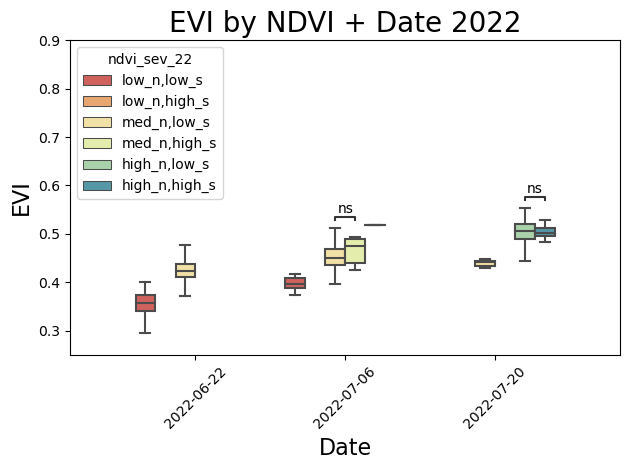

In [46]:
#Severity 2022

x = "Date"
y = "evi"
hue = "ndvi_sev_22"

hue_order=['low_n,low_s', 'low_n,high_s',
           'med_n,low_s', 'med_n,high_s',
          'high_n,low_s', 'high_n,high_s']

order = ['2022-06-22', '2022-07-06', '2022-07-20']
pairs=[
#     ((order[0], 'low_n,low_s'), (order[0], 'low_n,high_s')),
#     ((order[0], 'med_n,low_s'), (order[0], 'med_n,high_s')),
#     ((order[0], 'high_n,low_s'), (order[0], 'high_n,high_s')),
    
#     ((order[1], 'low_n,low_s'), (order[1], 'low_n,high_s')),
    ((order[1], 'med_n,low_s'), (order[1], 'med_n,high_s')),
#     ((order[1], 'high_n,low_s'), (order[1], 'high_n,high_s')),
    
#     ((order[2], 'low_n,low_s'), (order[2], 'low_n,high_s')),
#     ((order[2], 'med_n,low_s'), (order[2], 'med_n,high_s')),
    ((order[2], 'high_n,low_s'), (order[2], 'high_n,high_s')),

    ]

# colors = ["#4CAF50", "#FFDD33"]
# sns.set_palette(sns.color_palette(colors))

ax = sns.boxplot(data=dfs[2], x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['2022-06-22', '2022-07-06', '2022-07-20'], 
                   rotation=45)

add_stat_annotation(ax, data=dfs[2], x=x, y=y, order=order, hue=hue, hue_order=hue_order, box_pairs=pairs,
                     test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=16)
plt.ylabel("EVI", fontsize= 16)

plt.ylim(0.25, 0.9)
#plt.legend(title='Disease Severity',loc='upper left', labels=['<=10%', '>10%'], bbox_to_anchor=(1.02, 1))
##
#Test creating legend artist

# low_patch = mpatches.Patch(color='#4CAF50', label='<=10%')
# high_patch = mpatches.Patch(color='#FFDD33', label='>10%')

# plt.legend(title='GDM Severity',
#            loc='upper left',
#            #handles=[low_patch, high_patch],
#           bbox_to_anchor=(1.02, 1))

# plt.figtext(0.92, 0.5, 
#             'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001\n ****: p <= 1.00e-04', 
#             fontsize=12)

plt.title("EVI by NDVI + Date 2022", fontsize=20)

plt.tight_layout()
#plt.savefig("fig3_sev_2020.svg")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

2022-07-20_high_n,low_i v.s. 2022-07-20_high_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.360e-01 U_stat=1.117e+03
2022-06-22_med_n,low_i v.s. 2022-06-22_med_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.361e-01 U_stat=1.050e+02
2022-07-06_med_n,low_i v.s. 2022-07-06_med_n,high_i: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=7.769e-01 U_stat=9.860e+02


Text(0.5, 1.0, 'EVI by NDVI + Date 2022')

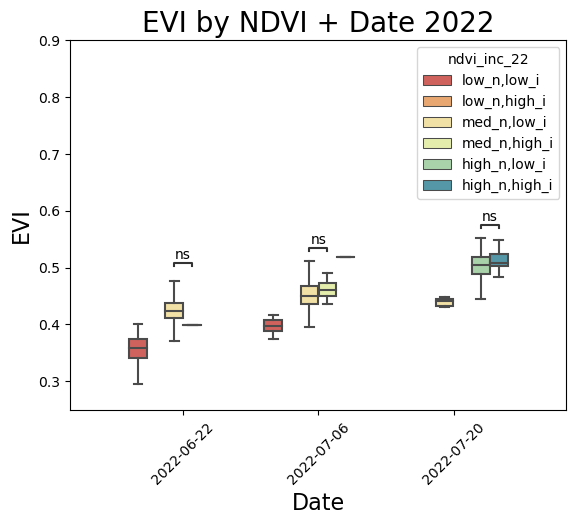

In [45]:
#Incidence 2022

x = "Date"
y = "evi"
hue = "ndvi_inc_22"

hue_order=['low_n,low_i', 'low_n,high_i',
           'med_n,low_i', 'med_n,high_i',
          'high_n,low_i', 'high_n,high_i']

order = ['2022-06-22', '2022-07-06', '2022-07-20']
pairs=[
    #((order[0], 'low_n,low_i'), (order[0], 'low_n,high_i')),
    ((order[0], 'med_n,low_i'), (order[0], 'med_n,high_i')),
    #((order[0], 'high_n,low_i'), (order[0], 'high_n,high_i')),
    
    #((order[1], 'low_n,low_i'), (order[1], 'low_n,high_i')),
    ((order[1], 'med_n,low_i'), (order[1], 'med_n,high_i')),
    #((order[1], 'high_n,low_i'), (order[1], 'high_n,high_i')),
    
    #((order[2], 'low_n,low_i'), (order[2], 'low_n,high_i')),
    #((order[2], 'med_n,low_i'), (order[2], 'med_n,high_i')),
    ((order[2], 'high_n,low_i'), (order[2], 'high_n,high_i')),
    ]

# colors = ["#4CAF50", "#FFDD33"]
#sns.color_palette("Spectral", as_cmap=True)
sns.set_palette("Spectral", n_colors=6)
# my_pal = {"low_n,low_i": "g", "low_n,high_i": "b", 
#           'med_n,low_i':, 'med_n,high_i':,
#           'high_n,low_i':, 'high_n,high_i':}

ax = sns.boxplot(data=dfs[2], x=x, y=y, order=order, hue=hue, hue_order=hue_order, showfliers = False)
ax.set_xticklabels(labels = ['2022-06-22', '2022-07-06', '2022-07-20'], 
                   rotation=45)

add_stat_annotation(ax, data=dfs[2], x=x, y=y, order=order, hue=hue, hue_order=hue_order, box_pairs=pairs,
                     test='Mann-Whitney', loc='inside', verbose=2)


plt.xlabel("Date", fontsize=16)
plt.ylabel("EVI", fontsize= 16)

plt.ylim(0.25, 0.9)
#plt.legend(title='Disease Severity',loc='upper left', labels=['<=10%', '>10%'], bbox_to_anchor=(1.02, 1))
##
#Test creating legend artist

# low_patch = mpatches.Patch(color='#4CAF50', label='<=10%')
# high_patch = mpatches.Patch(color='#FFDD33', label='>10%')

# plt.legend(title='GDM Severity',
#            loc='upper left',
#            #handles=[low_patch, high_patch],
#           bbox_to_anchor=(1.02, 1))

# plt.figtext(0.92, 0.5, 
#             'ns : not significant\n * : p < 0.05\n ** : p < 0.01\n *** : p < 0.001\n ****: p <= 1.00e-04', 
#             fontsize=12)

plt.title("EVI by NDVI + Date 2022", fontsize=20)

#plt.tight_layout()
#plt.savefig("fig3_sev_2020.svg")